In [1]:
import pandas as pd
import numpy as np

import pymc as pm
import arviz as az
import seaborn as sns

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# true values
p_true = np.array([0.10, 0.095, 0.105])  # index 0 is control; others are treatment variants

# sample size
n_total = 10000

weights_true = np.array([0.5, 0.3, 0.2])  # weights for control and treatment variants
group_labels = ['control'] + [f'treatment_{i}' for i in range(1, len(weights_true))]

n_samples = (weights_true * n_total).astype(int)

# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

In [3]:
# user_id, group, converted

def generate_dataframe(p, n, group_name):
    return pd.DataFrame({
        'user_id': np.arange(n),
        'group': [group_name for _ in range(n)],
        'converted': np.random.binomial(1, p, n)
    })

data_lst = []

for i, (p, n, group_name) in enumerate(zip(p_true, n_samples, group_labels)):
    data_lst.append(generate_dataframe(p, n, group_name))

data = pd.concat(data_lst)
data

,user_id,group,converted
0,0,control,0
1,1,control,0
2,2,control,0
3,3,control,0
4,4,control,0
...,...,...,...
1995,1995,treatment_2,0
1996,1996,treatment_2,0
1997,1997,treatment_2,0
1998,1998,treatment_2,0


<Axes: xlabel='converted', ylabel='count'>

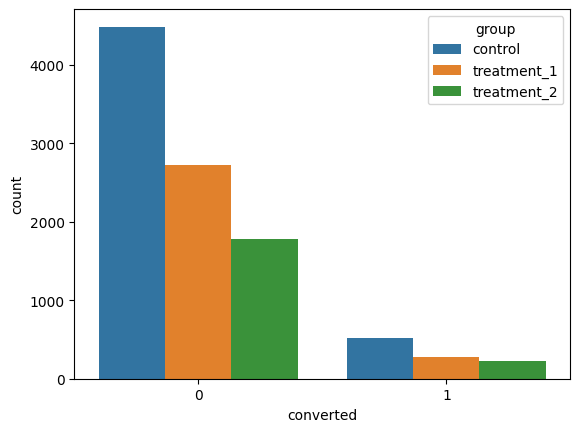

In [4]:
sns.countplot(x='converted', hue='group', data=data)

In [5]:
# Define the PyMC model
basic_model = pm.Model()

with basic_model:
    # Priors for the conversion rates of each group
    p = pm.Beta('p', alpha=1, beta=1, shape=len(group_labels))
    group_2_idx_mapping = data['group'].map({label: idx for idx, label in enumerate(group_labels)}).values
    p_selected_by_group = p[group_2_idx_mapping]

    # Likelihood (sampling distribution) of observations, with vectorized indexing
    pm.Bernoulli(
        'obs', 
        p=p_selected_by_group, 
        observed=data['converted']
    )

    # Calculate delta without prematurely evaluating `p`
    # Create a matrix where each entry `delta[k]` is calculated as p[k] - max(p without k)
    # pm.math.stack is the pymc equivalent of np.stack
    p_without_pk_max_list = []
    for k in range(len(group_labels)):
        p_without_pk_lst = [p[i] for i in range(len(group_labels)) if i != k]
        p_without_pk_vec = pm.math.stack(p_without_pk_lst)
        p_without_pk_max_list.append(pm.math.max(p_without_pk_vec))

    p_max_without_pk_vec = pm.math.stack(p_without_pk_max_list)
    
    
    delta = pm.Deterministic('delta', p - p_max_without_pk_vec)
    
    
    # Calculate max conversion rate across groups
    p_max = pm.math.max(p)
    
    # Loss function for each group
    loss = pm.Deterministic('loss', -(p - p_max))


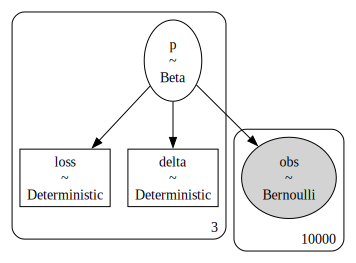

In [6]:
# requires brew/choco install graphviz in your local machine and add python package to pyproject.toml as well
pm.model_to_graphviz(basic_model)

In [7]:
n_draws = 1000
n_chains = 4
n_tune = 1000

with basic_model:
    # Sample from the posterior
    trace = pm.sample(
        draws=n_draws,
        chains=n_chains,
        tune=n_tune,
        random_seed=RANDOM_SEED,
        progressbar=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.


In [8]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>],
       [<Axes: title={'center': 'loss'}>,
        <Axes: title={'center': 'loss'}>]], dtype=object)

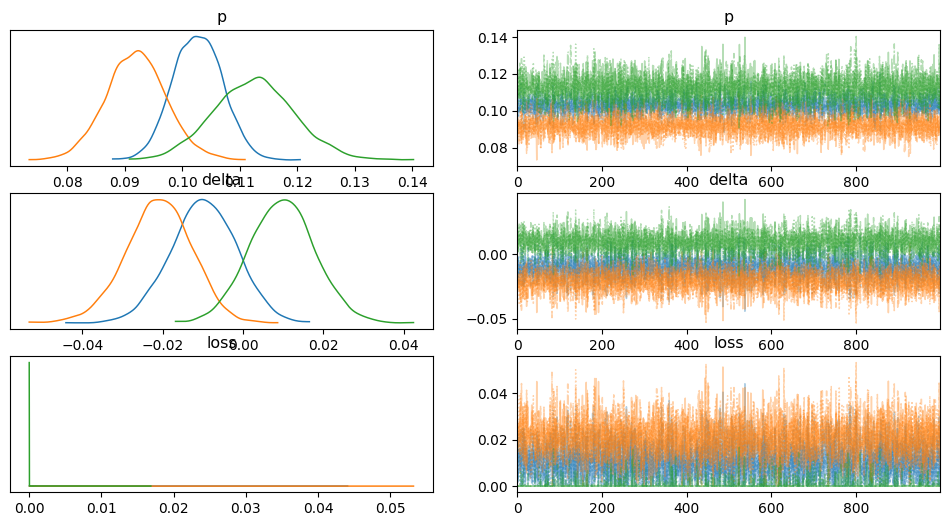

In [9]:
az.plot_trace(trace, combined=True)

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
p[0]      0.103  0.004   0.095    0.111        0.0      0.0    5919.0   
p[1]      0.092  0.005   0.081    0.101        0.0      0.0    5476.0   
p[2]      0.113  0.007   0.100    0.126        0.0      0.0    5932.0   
delta[0] -0.010  0.008  -0.025    0.005        0.0      0.0    5098.0   
delta[1] -0.021  0.008  -0.036   -0.006        0.0      0.0    4938.0   
delta[2]  0.010  0.008  -0.005    0.025        0.0      0.0    5151.0   
loss[0]   0.010  0.007  -0.000    0.023        0.0      0.0    5017.0   
loss[1]   0.021  0.008   0.006    0.036        0.0      0.0    4941.0   
loss[2]   0.000  0.002  -0.000    0.003        0.0      0.0    3332.0   

          ess_tail  r_hat  
p[0]        3061.0    1.0  
p[1]        2956.0    1.0  
p[2]        3057.0    1.0  
delta[0]    2984.0    1.0  
delta[1]    2924.0    1.0  
delta[2]    2662.0    1.0  
loss[0]     2984.0    1.0  
loss[1]     2924.0    1.0  
loss[2]     3414.

array([[<Axes: title={'center': 'p\n0'}>,
        <Axes: title={'center': 'p\n1'}>,
        <Axes: title={'center': 'p\n2'}>],
       [<Axes: title={'center': 'delta\n0'}>,
        <Axes: title={'center': 'delta\n1'}>,
        <Axes: title={'center': 'delta\n2'}>],
       [<Axes: title={'center': 'loss\n0'}>,
        <Axes: title={'center': 'loss\n1'}>,
        <Axes: title={'center': 'loss\n2'}>]], dtype=object)

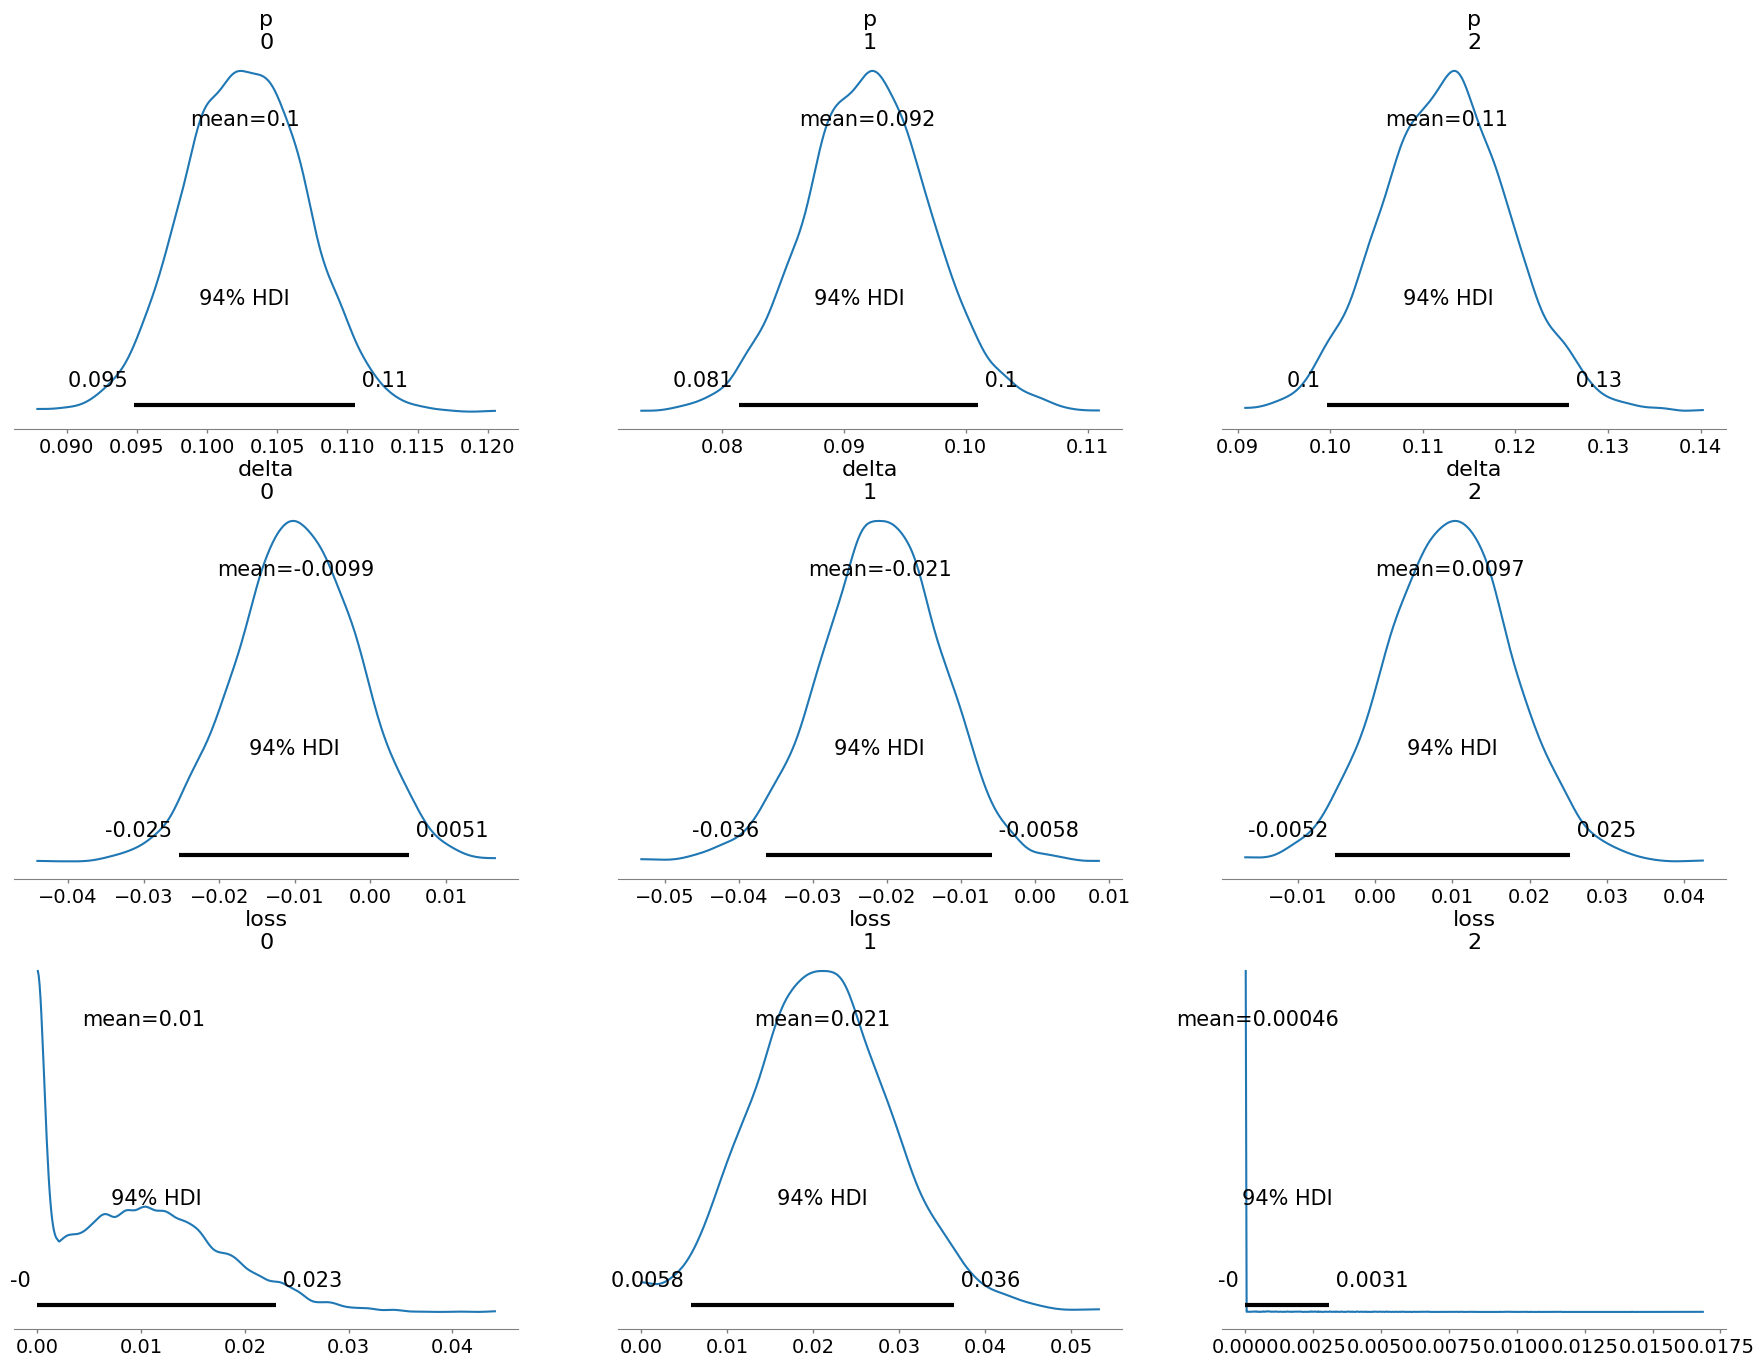

In [10]:
# Analyze the posterior distributions

# Summary statistics
print(az.summary(trace))

# Plot posterior distributions
az.plot_posterior(trace)

In [11]:
# Extract posterior samples
delta_samples = trace.posterior['delta'].values
loss = trace.posterior['loss'].values

In [12]:
delta_samples.shape, loss.shape

((4, 1000, 3), (4, 1000, 3))

In [13]:
# Probability that treatment is better than control
prob_better_treatment = np.mean(delta_samples > 0, axis=(0, 1))
print(f"Probability that treatment is better than the rest: {prob_better_treatment}")

# Expected loss if control is rolled out (missed opportunity)
expected_loss_per_group = loss.mean(axis=(0, 1))
print(f"Expected loss if variant is rolled out: {expected_loss_per_group}")


loss_ratio = expected_loss_per_group / expected_loss_per_group[0]
print(f"Ratio of expected losses: {loss_ratio}")

Probability that treatment is better than the rest: [0.11025 0.00525 0.8845 ]
Expected loss if variant is rolled out: [0.01028133 0.02102521 0.00046271]
Ratio of expected losses: [1.         2.04498864 0.04500482]


<Axes: >

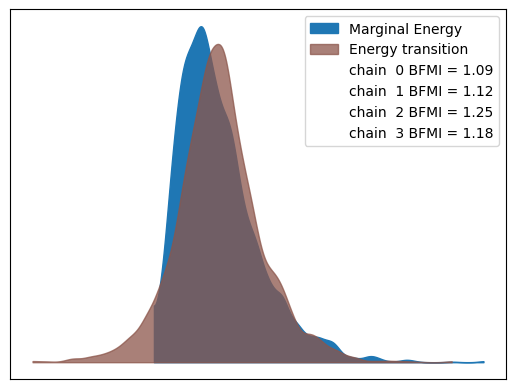

In [14]:
az.plot_energy(trace)

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

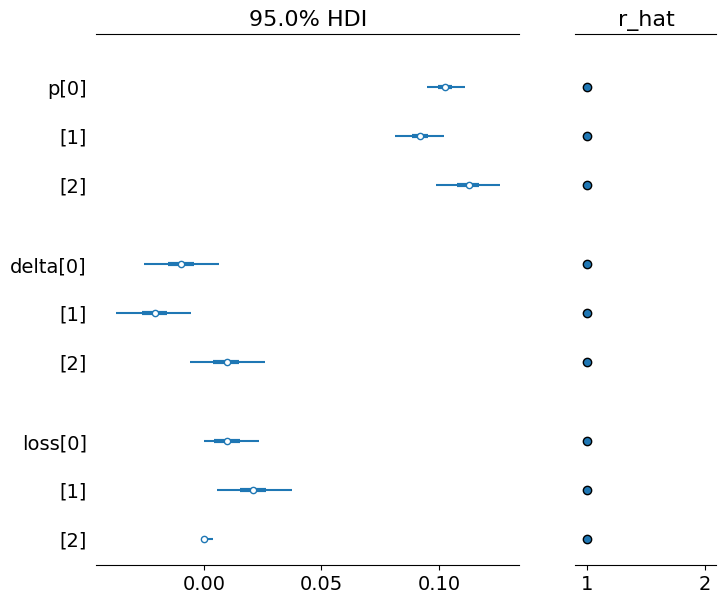

In [15]:
az.plot_forest(trace, combined=True, hdi_prob=0.95, r_hat=True)